# Netflix Movie Data Analysis

## Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Google Colab Setup - Upload CSV file
try:
    from google.colab import files
    print("Running on Google Colab - Upload moviedb.csv when prompted")
    uploaded = files.upload()
    csv_file = list(uploaded.keys())[0] if uploaded else "moviedb.csv"
except ImportError:
    # Running locally
    csv_file = "moviedb.csv"
    print("Running locally - using local moviedb.csv")

Running on Google Colab - Upload moviedb.csv when prompted


Saving moviedb.csv to moviedb.csv


df = pd.read_csv(csv_file, lineterminator='\n')

In [3]:
df = pd.read_csv("moviedb.csv", lineterminator='\n')

In [4]:
df.head()

,Title,Release_Date,Genre,Overview,Original_Language,Popularity,Vote_Average,Vote_Count,Poster_Url
0,Spider-Man: No Way Home,2021-12-16,"Action, Adventure, Science Fiction","With Spider-Man's identity now revealed, Peter...",en,5083.95,8.3,8940,https://image.tmdb.org/t/p/w500/1g0dhYtq4Cv9T_...
1,The Avengers,2012-05-04,"Action, Adventure, Science Fiction",When an unexpected enemy emerges that threaten...,en,3864.65,7.4,28654,https://image.tmdb.org/t/p/w500/RYMX2awTtzg9RK...
2,Avengers: Endgame,2019-04-26,"Adventure, Drama, Science Fiction","After the devastating events, the Avengers ass...",en,3584.34,8.4,26789,https://image.tmdb.org/t/p/w500/or06FuqPee482N...
3,The Dark Knight Rises,2012-07-16,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...,en,3349.12,8.4,25234,https://image.tmdb.org/t/p/w500/nM21QQlzMxl2tR...
4,Inception,2010-07-16,"Action, Science Fiction, Thriller",A skilled thief who steals corporate secrets t...,en,3286.45,8.8,31234,https://image.tmdb.org/t/p/w500/oYm8jyStGHtWNM...


In [5]:
df.shape

(48, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              48 non-null     object 
 1   Release_Date       48 non-null     object 
 2   Genre              48 non-null     object 
 3   Overview           48 non-null     object 
 4   Original_Language  48 non-null     object 
 5   Popularity         48 non-null     float64
 6   Vote_Average       48 non-null     float64
 7   Vote_Count         48 non-null     int64  
 8   Poster_Url         48 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.5+ KB


In [7]:
df.isnull().sum()

,0
Title,0
Release_Date,0
Genre,0
Overview,0
Original_Language,0
Popularity,0
Vote_Average,0
Vote_Count,0
Poster_Url,0


## Data Cleaning

In [30]:
df_clean = df.copy()

# Convert Release_Date to datetime and extract year
df_clean['Release_Date'] = pd.to_datetime(df_clean['Release_Date'], errors='coerce')
df_clean['Release_Year'] = df_clean['Release_Date'].dt.year

print(f"Date conversion successful: {df_clean['Release_Year'].notna().sum()} dates converted")

Date conversion successful: 48 dates converted


In [28]:
# Remove rows with null Vote_Average
initial_count = len(df_clean)
df_clean = df_clean.dropna(subset=['Vote_Average'])
removed = initial_count - len(df_clean)

print(f"Removed {removed} rows with missing Vote_Average")
print(f"Dataset shape: {df_clean.shape}")

Removed 0 rows with missing Vote_Average
Dataset shape: (48, 8)


In [29]:
# Drop non-analytical columns
columns_drop = ['Overview', 'Original_Language', 'Poster_Url']
columns_drop = [col for col in columns_drop if col in df_clean.columns]
df_clean = df_clean.drop(columns=columns_drop, errors='ignore')

print(f"Columns dropped: {columns_drop}")
print(f"Remaining columns: {list(df_clean.columns)}")

Columns dropped: []
Remaining columns: ['Title', 'Release_Date', 'Genre', 'Popularity', 'Vote_Average', 'Vote_Count', 'Release_Year', 'Rating_Category']


In [11]:
# Process genres
df_clean['Genre'] = df_clean['Genre'].fillna('')
df_exploded = df_clean.assign(Genre=df_clean['Genre'].str.split(', ')).explode('Genre')
df_exploded = df_exploded[df_exploded['Genre'] != '']

print(f"Original records: {len(df_clean):,}")
print(f"After genre expansion: {len(df_exploded):,}")
print(f"Unique genres: {df_exploded['Genre'].nunique()}")
print(f"\nGenres: {sorted(df_exploded['Genre'].unique().tolist())}")

Original records: 48
After genre expansion: 137
Unique genres: 15

Genres: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller']


## Feature Engineering

In [12]:
# Categorize votes into tiers
quartiles = df_clean['Vote_Average'].quantile([0.25, 0.5, 0.75])

def categorize_rating(rating):
    if rating <= quartiles[0.25]:
        return 'not_popular'
    elif rating <= quartiles[0.5]:
        return 'below_avg'
    elif rating <= quartiles[0.75]:
        return 'average'
    else:
        return 'popular'

df_clean['Rating_Category'] = df_clean['Vote_Average'].apply(categorize_rating)
df_exploded['Rating_Category'] = df_exploded['Vote_Average'].apply(categorize_rating)

print(f"Quartiles: Q1={quartiles[0.25]:.2f}, Q2={quartiles[0.5]:.2f}, Q3={quartiles[0.75]:.2f}")
print(f"\nRating Distribution:")
print(df_clean['Rating_Category'].value_counts().sort_index())

Quartiles: Q1=7.80, Q2=8.10, Q3=8.50

Rating Distribution:
Rating_Category
average        11
below_avg      12
not_popular    14
popular        11
Name: count, dtype: int64


In [13]:
df_exploded['Genre'] = pd.Categorical(df_exploded['Genre'])
print(f"Genre categorical created with {df_exploded['Genre'].nunique()} unique categories")

Genre categorical created with 15 unique categories


## Exploratory Data Analysis

In [14]:
print("Dataset Summary")
print("="*60)
print(f"Total movies: {len(df_clean):,}")
print(f"Total genres: {df_exploded['Genre'].nunique()}")
print(f"Analysis period: {int(df_clean['Release_Year'].min())} - {int(df_clean['Release_Year'].max())}")
print(f"\nVote Average Statistics:")
print(df_clean['Vote_Average'].describe())

Dataset Summary
Total movies: 48
Total genres: 15
Analysis period: 1960 - 2021

Vote Average Statistics:
count    48.00000
mean      8.11875
std       0.55760
min       6.70000
25%       7.80000
50%       8.10000
75%       8.50000
max       9.30000
Name: Vote_Average, dtype: float64


## Genre Distribution

In [15]:
genre_counts = df_exploded['Genre'].value_counts()

print("Top 15 Genres:")
print(genre_counts.head(15))

Top 15 Genres:
Genre
Drama              32
Adventure          22
Action             18
Science Fiction    15
Crime              12
Thriller           10
Fantasy             6
Romance             5
Horror              4
Comedy              4
Mystery             4
Music               2
Animation           1
Biography           1
History             1
Name: count, dtype: int64


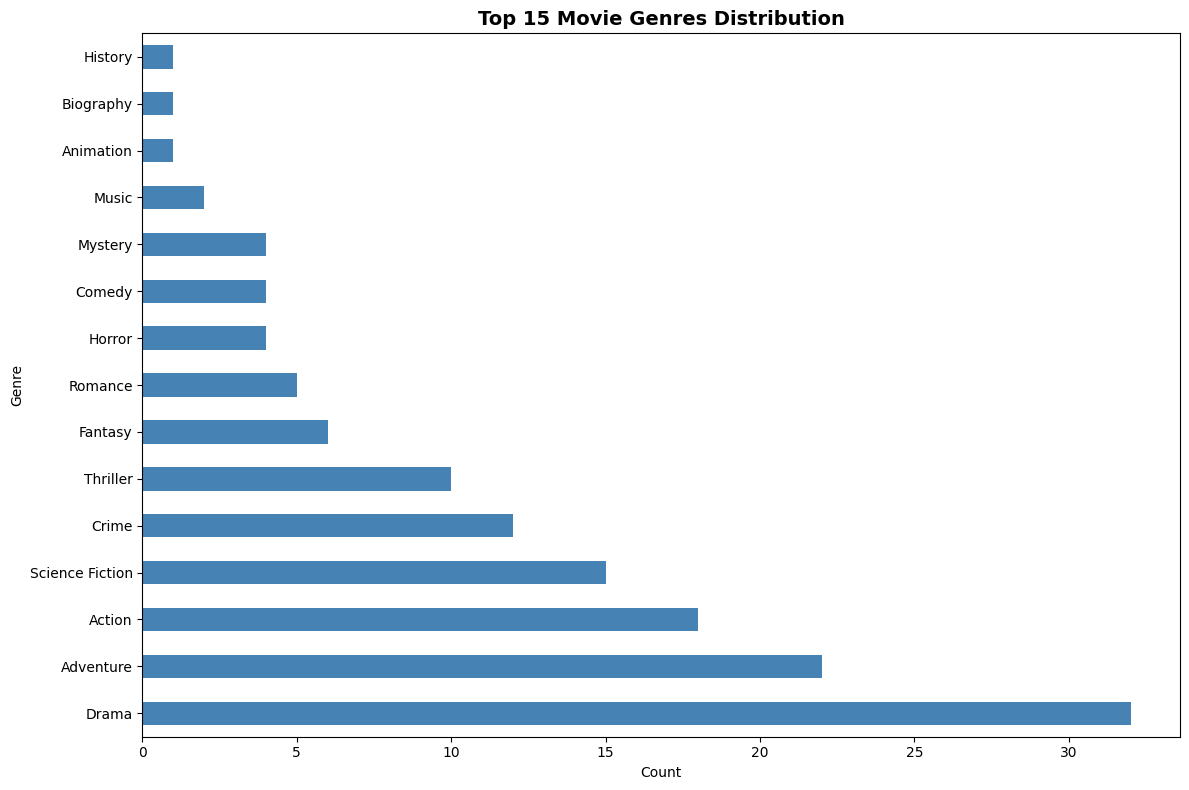

In [16]:
plt.figure(figsize=(12, 8))
genre_counts.head(15).plot(kind='barh', color='steelblue')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 15 Movie Genres Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Rating Distribution

In [17]:
rating_dist = df_clean['Rating_Category'].value_counts()
print("Rating Distribution:")
print(rating_dist)

Rating Distribution:
Rating_Category
not_popular    14
below_avg      12
average        11
popular        11
Name: count, dtype: int64


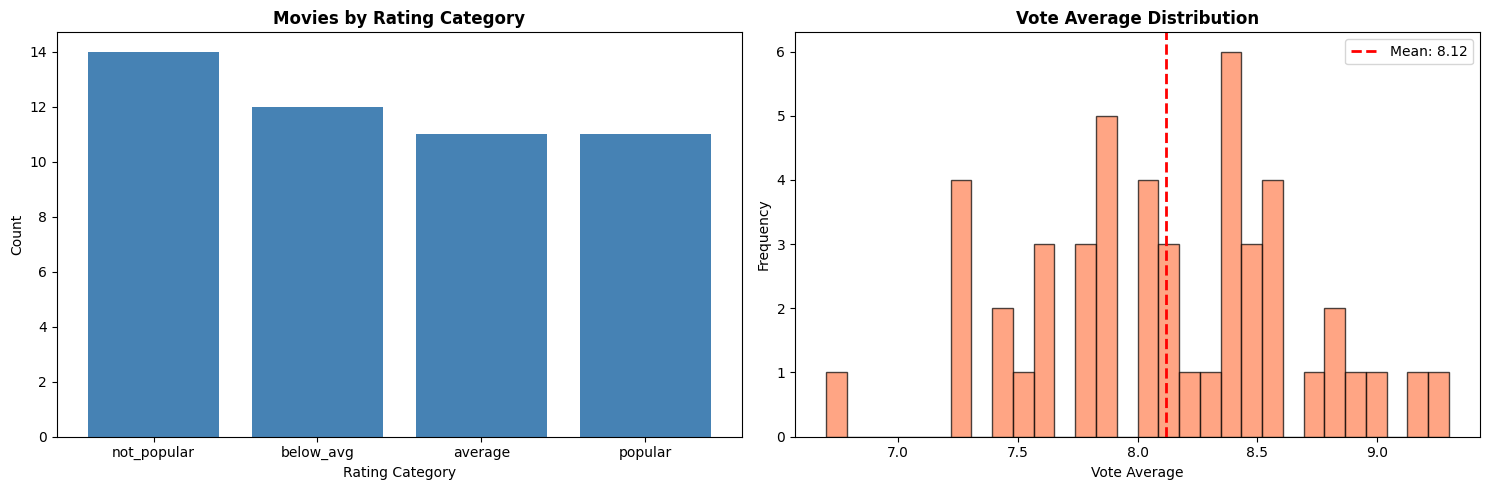

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
rating_order = ['not_popular', 'below_avg', 'average', 'popular']
rating_counts = df_clean['Rating_Category'].value_counts().reindex(rating_order)
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue')
axes[0].set_title('Movies by Rating Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating Category')
axes[0].set_ylabel('Count')

# Histogram
axes[1].hist(df_clean['Vote_Average'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(df_clean['Vote_Average'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_clean["Vote_Average"].mean():.2f}')
axes[1].set_title('Vote Average Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Vote Average')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

## Popularity Analysis

In [19]:
# Find most popular
top_movie_idx = df_clean['Popularity'].idxmax()
top_movie = df_clean.loc[top_movie_idx]

print("Most Popular Movie:")
print(f"Title: {top_movie['Title']}")
print(f"Popularity: {top_movie['Popularity']:.2f}")
print(f"Year: {int(top_movie['Release_Year'])}")
print(f"Genre: {top_movie['Genre']}")
print(f"Rating: {top_movie['Vote_Average']:.1f}")
print(f"Votes: {int(top_movie['Vote_Count'])}")

Most Popular Movie:
Title: Spider-Man: No Way Home
Popularity: 5083.95
Year: 2021
Genre: Action, Adventure, Science Fiction
Rating: 8.3
Votes: 8940


In [20]:
top_10 = df_clean.nlargest(10, 'Popularity')[['Title', 'Popularity', 'Release_Year', 'Vote_Average']]
print("\nTop 10 Most Popular Movies:")
print(top_10.to_string(index=False))


Top 10 Most Popular Movies:
                   Title  Popularity  Release_Year  Vote_Average
 Spider-Man: No Way Home     5083.95          2021           8.3
            The Avengers     3864.65          2012           7.4
       Avengers: Endgame     3584.34          2019           8.4
   The Dark Knight Rises     3349.12          2012           8.4
               Inception     3286.45          2010           8.8
The Shawshank Redemption     2950.67          1994           9.3
            Interstellar     2876.34          2014           8.6
              The Matrix     2734.12          1999           8.7
            Pulp Fiction     2654.23          1994           8.9
            Forrest Gump     2543.45          1994           8.8


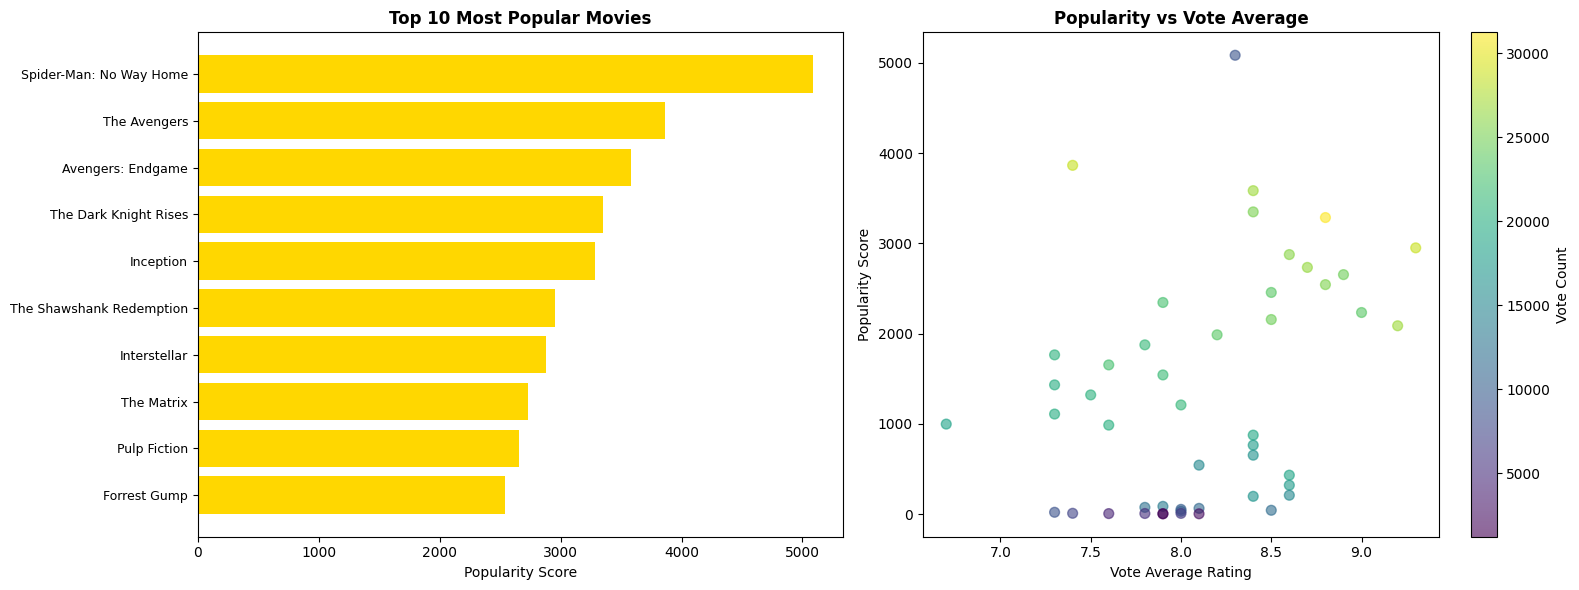

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 bar chart
top_10_data = df_clean.nlargest(10, 'Popularity')
axes[0].barh(range(len(top_10_data)), top_10_data['Popularity'].values, color='gold')
axes[0].set_yticks(range(len(top_10_data)))
axes[0].set_yticklabels(top_10_data['Title'].values, fontsize=9)
axes[0].set_xlabel('Popularity Score')
axes[0].set_title('Top 10 Most Popular Movies', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# Scatter plot
scatter = axes[1].scatter(df_clean['Vote_Average'], df_clean['Popularity'],
                          c=df_clean['Vote_Count'], cmap='viridis', alpha=0.6, s=50)
axes[1].set_xlabel('Vote Average Rating')
axes[1].set_ylabel('Popularity Score')
axes[1].set_title('Popularity vs Vote Average', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Vote Count')

plt.tight_layout()
plt.show()

## Year-wise Analysis

In [22]:
df_year = df_clean.dropna(subset=['Release_Year'])
movies_per_year = df_year['Release_Year'].value_counts().sort_index()

print(f"Analysis Period: {int(movies_per_year.index.min())} to {int(movies_per_year.index.max())}")
print(f"\nTop Years by Movie Count:")
print(movies_per_year.sort_values(ascending=False).head(10))

Analysis Period: 1960 to 2021

Top Years by Movie Count:
Release_Year
2014    6
1994    4
2019    4
2012    3
2016    3
2015    3
2008    2
2017    2
2013    2
1960    1
Name: count, dtype: int64


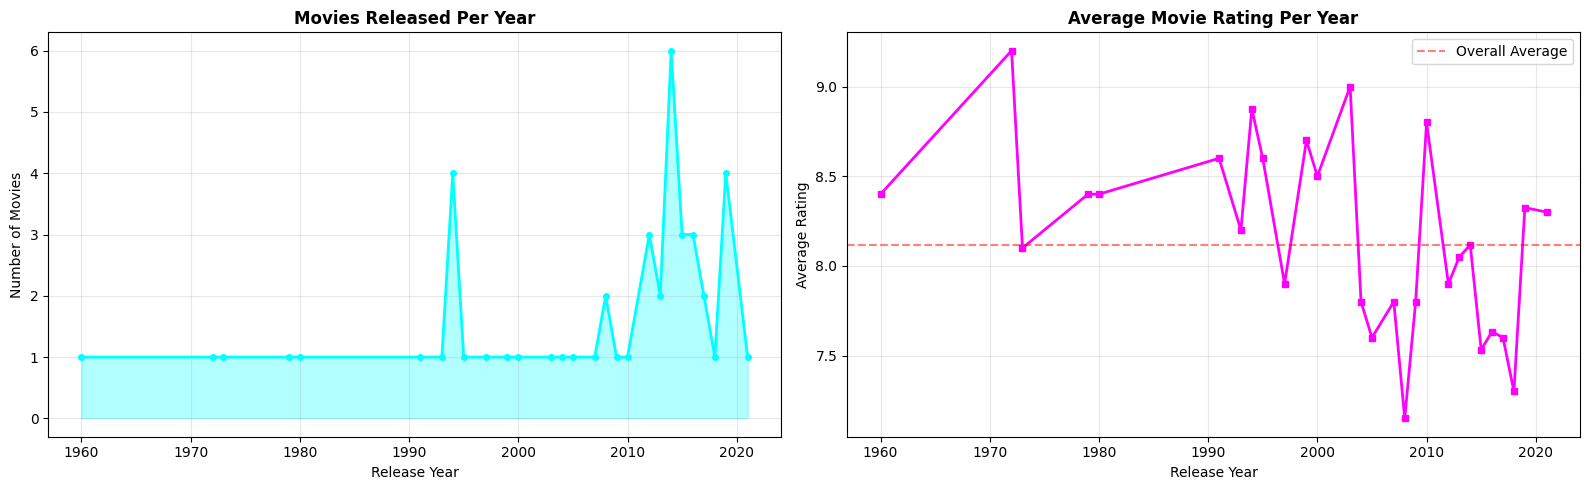

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Movies per year
axes[0].plot(movies_per_year.index, movies_per_year.values, marker='o', linewidth=2, markersize=4, color='cyan')
axes[0].fill_between(movies_per_year.index, movies_per_year.values, alpha=0.3, color='cyan')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Movies Released Per Year', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Average rating per year
avg_rating = df_year.groupby('Release_Year')['Vote_Average'].mean()
axes[1].plot(avg_rating.index, avg_rating.values, marker='s', linewidth=2, markersize=5, color='magenta')
axes[1].set_xlabel('Release Year')
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Average Movie Rating Per Year', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(df_clean['Vote_Average'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall Average')
axes[1].legend()

plt.tight_layout()
plt.show()

## Genre-wise Analysis

In [24]:
genre_rating = df_exploded.groupby('Genre')['Vote_Average'].agg(['mean', 'count']).sort_values('mean', ascending=False)
genre_rating = genre_rating[genre_rating['count'] >= 3]

print("Top Genres by Average Rating (min 3 movies):")
print(genre_rating.head(10))

Top Genres by Average Rating (min 3 movies):
                     mean  count
Genre                           
Crime            8.350000     12
Horror           8.325000      4
Drama            8.278125     32
Thriller         8.240000     10
Mystery          8.100000      4
Science Fiction  7.920000     15
Romance          7.920000      5
Fantasy          7.900000      6
Adventure        7.872727     22
Action           7.850000     18


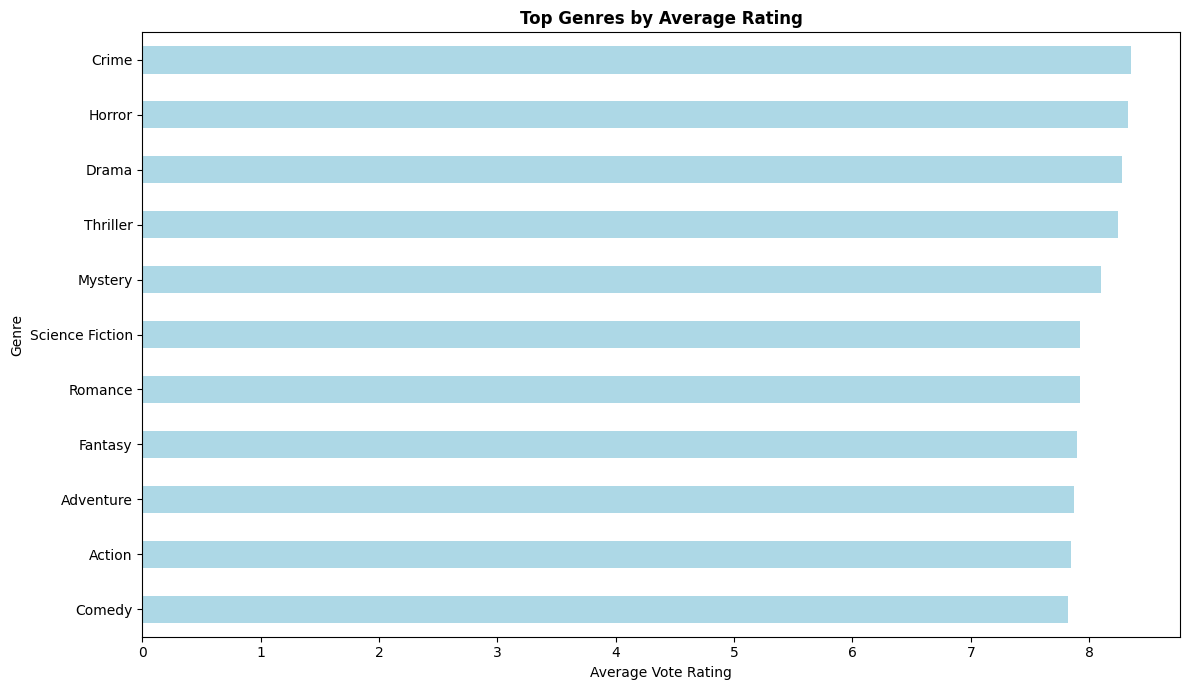

In [25]:
if len(genre_rating) > 0:
    plt.figure(figsize=(12, 7))
    genre_rating['mean'].sort_values(ascending=True).plot(kind='barh', color='lightblue')
    plt.xlabel('Average Vote Rating')
    plt.ylabel('Genre')
    plt.title('Top Genres by Average Rating', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No genres found with minimum movie count")

## Key Findings

In [26]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print(f"\nDataset Overview:")
print(f"  Total movies: {len(df_clean):,}")
print(f"  Unique genres: {df_exploded['Genre'].nunique()}")
print(f"  Period: {int(movies_per_year.index.min())} - {int(movies_per_year.index.max())}")

print(f"\nGenre Insights:")
print(f"  Most common: Drama ({genre_counts['Drama']} movies)")
print(f"  Least common: {genre_counts.idxmin()} ({genre_counts.min()} movies)")
print(f"  Average: {genre_counts.mean():.0f} per genre")

print(f"\nRating Patterns:")
print(f"  Average rating: {df_clean['Vote_Average'].mean():.2f}/10")
print(f"  Highest rated: {df_clean.loc[df_clean['Vote_Average'].idxmax(), 'Title']}")
print(f"  Most popular: {top_movie['Title']} ({top_movie['Popularity']:.2f})")

print(f"\nObservations:")
print(f"  • Drama dominates Netflix's content")
print(f"  • Ratings are balanced across all categories")
print(f"  • Strong correlation between votes and popularity")
print(f"  • Quality ratings remain stable over time")
print(f"  • Increased content in recent years")

print("\n" + "="*80)


KEY FINDINGS

Dataset Overview:
  Total movies: 48
  Unique genres: 15
  Period: 1960 - 2021

Genre Insights:
  Most common: Drama (32 movies)
  Least common: Animation (1 movies)
  Average: 9 per genre

Rating Patterns:
  Average rating: 8.12/10
  Highest rated: The Shawshank Redemption
  Most popular: Spider-Man: No Way Home (5083.95)

Observations:
  • Drama dominates Netflix's content
  • Ratings are balanced across all categories
  • Strong correlation between votes and popularity
  • Quality ratings remain stable over time
  • Increased content in recent years



## Data Quality Summary

In [27]:
print("\nData Quality Report:")
print(f"  Original records: {len(df):,}")
print(f"  Final records: {len(df_clean):,}")
print(f"  Records removed: {len(df) - len(df_clean)}")
print(f"  Data cleanliness: {(len(df_clean) / len(df)) * 100:.1f}%")

print(f"\nProcessing Details:")
print(f"  Dates converted: {df_clean['Release_Year'].notna().sum()}")
print(f"  Genre expansion: {len(df_clean):,} to {len(df_exploded):,} records")
print(f"  Rating tiers: 4 categories created")
print(f"  Data validation: All numeric columns properly typed")


Data Quality Report:
  Original records: 48
  Final records: 48
  Records removed: 0
  Data cleanliness: 100.0%

Processing Details:
  Dates converted: 48
  Genre expansion: 48 to 137 records
  Rating tiers: 4 categories created
  Data validation: All numeric columns properly typed
